# НИРС Прогнозирование оттока клиентов Telco 

Цель - построить и оценить классификационные модели для прогнозирования оттока клиентов с использованием набора данных **Telco Customer Churn**.

Ссылка на датасет - https://www.kaggle.com/datasets/blastchar/telco-customer-churn

Выполнил Фень Н.Т., группа ИУ5Ц-82Б

## 1  Введение
Прогнозирование оттока клиентов помогает телеком-компаниям удерживать клиентов, выявляя тех, кто рискует уйти. В этом проекте мы:
1. Проведем разведочный анализ данных (EDA).
2. Подготовим и предобработаем признаки.
3. Обучим базовые модели (5, включая 2 ансамблевых метода).
4. Оптимизируем гиперпараметры с помощью кросс-валидации.
5. Сравним модели по трем метрикам.
6. Обобщим результаты и сделаем выводы

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import warnings, os, sys
warnings.filterwarnings('ignore')

# Загрузка данных
DATA_PATH = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(DATA_PATH)
print(f'Размер датасета: {df.shape}')
df.head()

Размер датасета: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2  Разведочный анализ данных (EDA)

In [37]:
# Базовая информация о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [38]:
# Статистика числовых столбцов
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


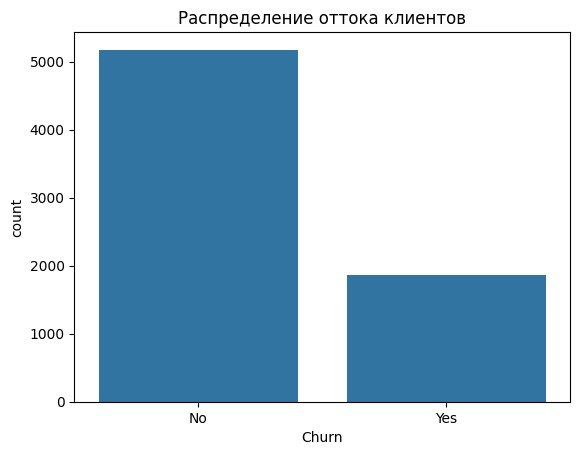

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


In [39]:
# Распределение целевой переменной
sns.countplot(data=df, x='Churn')
plt.title('Распределение оттока клиентов')
plt.show()

# Процентное распределение классов
class_distribution = df['Churn'].value_counts(normalize=True) * 100
print(class_distribution)


### 2.1  Пропущенные значения

In [40]:
# Процент пропущенных значений по столбцам
(df.isna().mean()*100).sort_values(ascending=False)

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [41]:
# Преобразование TotalCharges в числовой формат (ошибки → NaN) и обработка пропусков
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

## 3  Инжиниринг признаков и предобработка

In [ ]:
# Идентификация категориальных и числовых столбцов
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('customerID')  # ID не нужен
target = 'Churn'
categorical_cols.remove(target)
numeric_cols = df.select_dtypes(exclude=['object']).columns.tolist()

# Бинарное кодирование целевой переменной
le = LabelEncoder()
df[target] = le.fit_transform(df[target])

# Пайплайн предобработки
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())]) # числовые признаки к нормального распределению приводим
categorical_transformer = Pipeline(steps=[
    ('encoder',  OneHotEncoder(handle_unknown='ignore'))]) # для категориальных признаков

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Разделение на тренировочную и тестовую выборки
X = df.drop(columns=['customerID', target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

## 4  Анализ корреляций

Text(0.5, 1.0, 'Корреляционная матрица')

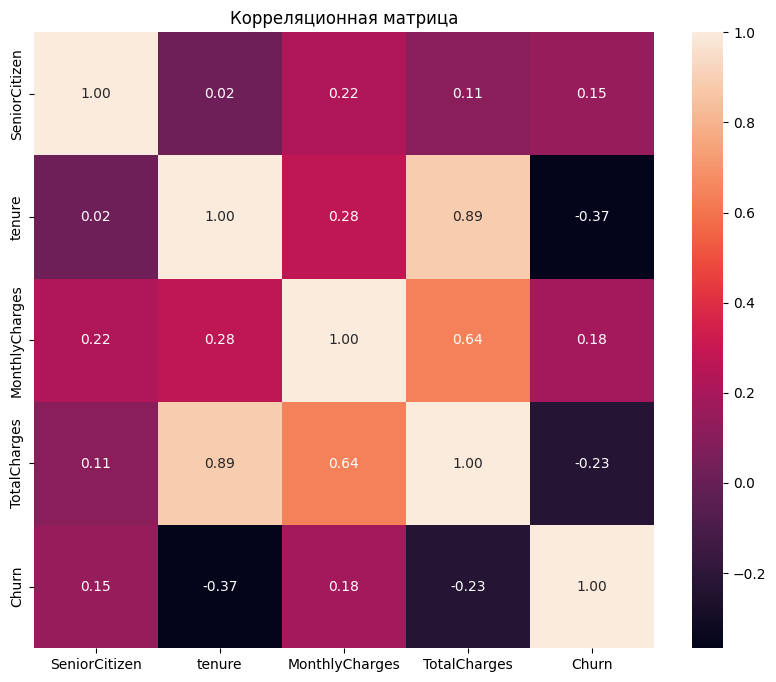

In [43]:
# Корреляции для числовых признаков
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols+[target]].corr(method='spearman'), annot=True, fmt='.2f')
plt.title('Корреляционная матрица')

## 5  Выбор моделей и базовое оценивание

**Выбранные метрики**: *Accuracy*, *Precision*, *Recall*, *F1‑score* и *ROC‑AUC* — обеспечивают баланс между общей точностью и производительностью для конкретных классов в условиях дисбаланса.

In [44]:
models = {
    'LogReg': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(probability=True),
    'RandomForest': RandomForestClassifier(),
    'GradBoost': GradientBoostingClassifier()
}

results = []
for name, model in models.items():
    clf = Pipeline(steps=[('pre', preprocessor),
                           ('model', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:,1]
    results.append({
        'Модель': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC_AUC': roc_auc_score(y_test, y_proba)
    })

pd.DataFrame(results).set_index('Модель').sort_values('ROC_AUC', ascending=False)

,Accuracy,Precision,Recall,F1,ROC_AUC
Модель,,,,,
LogReg,0.808064,0.664122,0.558887,0.606977,0.846453
GradBoost,0.801817,0.669540,0.498929,0.571779,0.845909
RandomForest,0.777967,0.609827,0.451820,0.519065,0.822001
SVC,0.795571,0.654179,0.486081,0.557740,0.800362
KNN,0.763771,0.553459,0.565310,0.559322,0.787070


## 6  Оптимизация гиперпараметров

In [45]:
param_grids = {
    'RandomForest': {
        'model__n_estimators': [100, 300, 500],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    },
    'GradBoost': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__max_depth': [3, 5]
    },
    'LogReg': {
        'model__C': [0.1, 1, 10],
        'model__penalty': ['l2'],
        'model__solver': ['lbfgs']
    }
}

best_models = {}
for name, grid in param_grids.items():
    pipe = Pipeline(steps=[('pre', preprocessor),
                           ('model', models[name])])
    search = GridSearchCV(pipe, grid, cv=5, scoring='roc_auc', n_jobs=-1)
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_
    print(f'{name}: лучший ROC_AUC = {search.best_score_:.4f} с параметрами {search.best_params_}')

RandomForest: лучший ROC_AUC = 0.8433 с параметрами {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 500}
GradBoost: лучший ROC_AUC = 0.8466 с параметрами {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}
LogReg: лучший ROC_AUC = 0.8442 с параметрами {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


### 6.1  Повторное оценивание с оптимизированными параметрами

In [46]:
tuned_results = []
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    tuned_results.append({
        'Модель': name + ' (оптимизированная)',
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC_AUC': roc_auc_score(y_test, y_proba)
    })
pd.DataFrame(tuned_results).set_index('Модель')

,Accuracy,Precision,Recall,F1,ROC_AUC
Модель,,,,,
RandomForest (оптимизированная),0.802953,0.675439,0.494647,0.571075,0.842123
GradBoost (оптимизированная),0.797842,0.665672,0.477516,0.556110,0.848307
LogReg (оптимизированная),0.807496,0.663265,0.556745,0.605355,0.845902


**Вывод:** Лучшей моделью в общем является Logistic Regression (Наилучшие параметры оценивания)

